<a href="https://colab.research.google.com/github/EsmeBarker/Collab/blob/main/EsmeBarkU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Context**

In [ ]:
!pip install preliz

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import preliz as pz
import pymc as pm
import arviz as az

For my U2 project, I looked at how many of Fritz's(American pro tennis player) matches went over 2 hours. For this project, I want to find the actual average length of his matches via a normal distribution.

As I mentioned previously, this is interesting to look at because tennis matches have no upper or lower limit for length, and as someone who plays a lot of tennis but doesn't watch much, I want to find out more about what average match lengths look like for a professional.

Once again, I am only including matches that were best 2 of 3 six game sets format, excluding any matches ending in withdrawls. I noted at the end of my U2 project that there were still some issues with the data I chose to use. Specifically, the fact that I included his matches from any point in his career(even ones from almost 10 years ago) and that I used data from all different court types, even though I know that can influence match speed. To improve my project this time, I will only be looking at matches from 2020 or later, and only ones played on hard courts(the most common type).

Downloading Fritz's data

In [5]:
fritz_url = 'https://raw.githubusercontent.com/EsmeBarker/Collab/refs/heads/main/Fritz%20-%20Sheet1%20(2).csv'
fritz_data = pd.read_csv(fritz_url)
fritz_data

,Date,Tournament,Surface,Rd,Rk,vRk,Unnamed: 6,Score,DR,A%,DF%,1stIn,1st%,2nd%,BPSvd,Time
0,6‑Jan‑2020,Atp Cup,Hard,RR,31,17,Karen Khachanov [RUS] d. Fritz,3-6 7-5 6-1,0.73,12.40%,6.70%,59.60%,79.20%,30.60%,3/7,1:51:00
1,6‑Jan‑2020,Atp Cup,Hard,RR,31,82,Stefano Travaglia [ITA] d. Fritz,7-6(3) 7-6(1),0.68,7.40%,2.50%,70.40%,68.40%,62.50%,5/6,1:42:00
2,6‑Jan‑2020,Atp Cup,Hard,RR,31,329,Fritz d. Viktor Durasovic [NOR],6-2 6-2,3.31,28.20%,5.10%,59.00%,95.70%,68.80%,1/1,1:01:00
3,13‑Jan‑2020,Adelaide,Hard,R32,32,55,Alexander Bublik [KAZ] d. (5)Fritz,6-4 7-6(4),0.87,12.20%,1.20%,62.20%,60.80%,67.70%,3/4,1:36:00
4,27‑Jan‑2020,Newport Beach CH,Hard,R16,34,164,(13)Mitchell Krueger [USA] d. (1)Fritz,6-4 3-6 6-3,0.90,20.00%,2.50%,62.50%,80.00%,53.30%,3/5,1:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,27‑Jul‑2025,Canada Masters,Hard,R32,4,36,(2)Fritz d. (27)Gabriel Diallo [CAN],6-4 6-2,2.13,10.40%,0.00%,54.20%,88.50%,68.20%,1/1,1:15:00
191,27‑Jul‑2025,Canada Masters,Hard,R64,4,89,(2)Fritz d. Roberto Carballes Baena [ESP],7-5 7-6(1),1.31,10.30%,3.80%,59.00%,82.60%,46.90%,4/6,2:31:00
192,7‑Aug‑2025,Cincinnati Masters,Hard,R16,4,136,(Q)Terence Atmane [FRA] d. (4)Fritz,3-6 7-5 6-3,0.90,7.60%,2.20%,65.20%,76.70%,43.80%,3/6,1:59:00
193,7‑Aug‑2025,Cincinnati Masters,Hard,R32,4,36,(4)Fritz d. (31)Lorenzo Sonego [ITA],7-6(4) 7-5,1.65,19.70%,3.00%,56.10%,86.50%,72.40%,0/0,2:07:00


Taking the "time" column and turning it into minutes to make it more graphable.

In [6]:
#I tried to do the same thing here as last time to make pandas like my time column more, and it didn't work. This is what gemeni suggested to convert my time column into minutes, and the suggestion worked great so I went with it.
fritz_time = fritz_data['Time']
fritz_minutes = fritz_time.str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
display(fritz_minutes)

,Time
0,111
1,102
2,61
3,96
4,95
...,...
190,75
191,151
192,119
193,127


Displaying Fritz's match lengths in minutes in a histogram

(array([13., 31., 28., 34., 27., 19., 21.,  9.,  8.,  5.]),
 array([ 50. ,  63.6,  77.2,  90.8, 104.4, 118. , 131.6, 145.2, 158.8,
        172.4, 186. ]),
 <BarContainer object of 10 artists>)

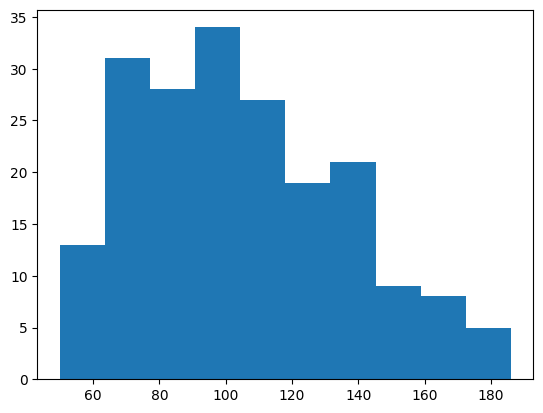

In [ ]:
plt.hist(fritz_minutes)

I'm using a normal distribution for my first likelihood, because that seems like a good place to start and it makes logical sense to me based on my own experience.

My first prior is my estimation for the "mu" value of the normal distribution. The average length of a tennis match(based on googling and my own playing) is around 90 minutes, so that is my center for this prior. I would expect that to vary a fair bit but not too much, so I made my sigma 15.

<Axes: >

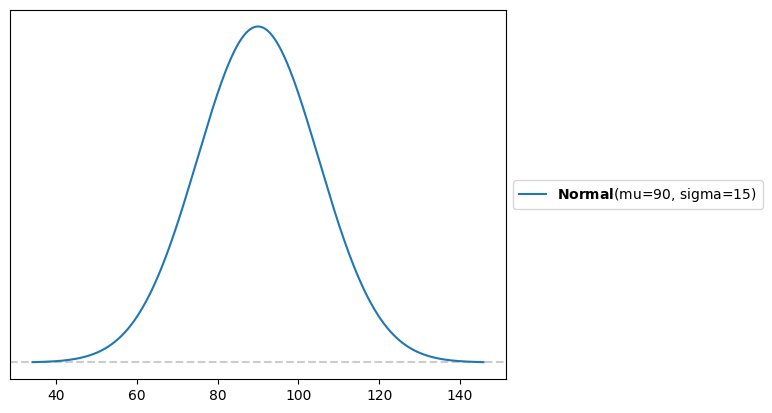

In [3]:
pz.Normal(mu=90,sigma=15).plot_pdf()

For my second prior, I used a half normal distribution to make sure that smaller, positive sigma values were represented, with sigma = 30 because that felt like a reasonable amount of variation from average tennis match length based on my experience

<Axes: >

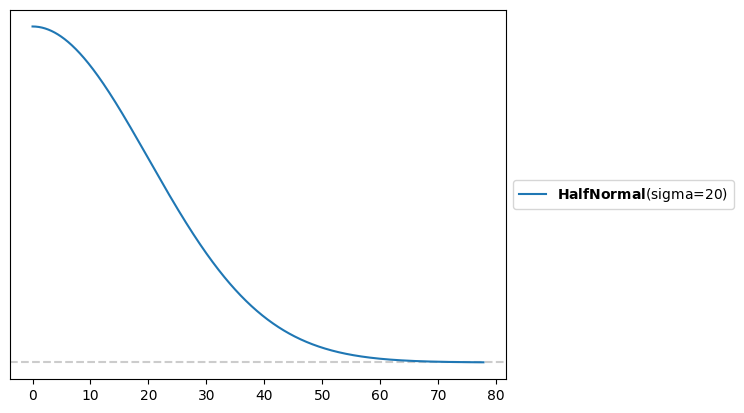

In [ ]:
pz.HalfNormal(sigma = 30).plot_pdf()

Finally, I put together my priors to create a full model. This combined my predictions for the mu and sigma values with the actual observed data to form my first attempt at graphing Fritz's average match length.

In [ ]:
with pm.Model() as fritz_model:
    μ = pm.Normal('mu', mu=90, sigma=15)


    σ = pm.HalfNormal('σ', sigma=30)

    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=fritz_minutes)
    fritz_info= pm.sample()

As you can see below, this did not work out too well. My posterior isn't insanely far off from the observed data, but it's clear that there was more of a right skew to it that wasn't represented in my normal distribution.

In [ ]:
pm.sample_posterior_predictive(fritz_info, model=fritz_model, extend_inferencedata=True)


<Axes: xlabel='Y'>

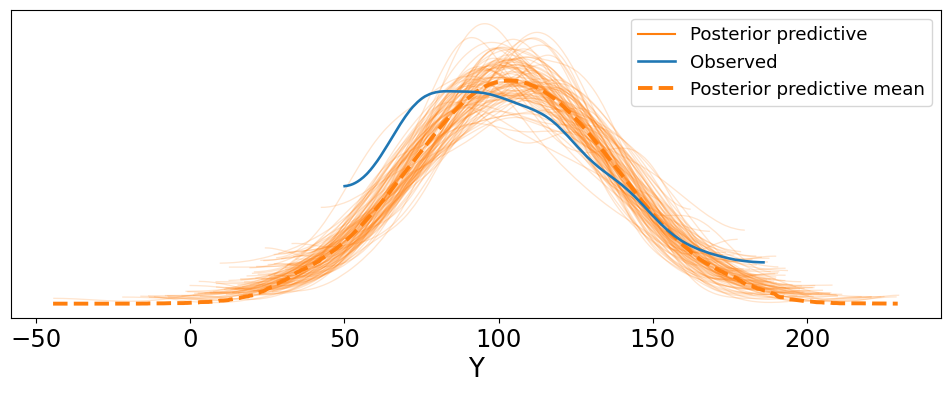

In [11]:
az.plot_ppc(fritz_info, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Attempt 2**

To try to solve this problem in my second attempt, I used a skew normal for my liklihood. I chose this because I felt like the data was still fairly normal, but I needed a way to account for the right skew.

In [ ]:
with pm.Model() as fritz_model_2:
  μ = pm.Normal('mu', mu=90, sigma=15)
  σ = pm.HalfNormal('σ', sigma=30)
  #I wasn't really sure what the alpha should look like, I just knew it needed to be positive. I used a uniform distribution from 0 to 10 for this prior to make sure that the skew was enough but not too extreme.
  α = pm.Uniform('α', lower=0, upper=10)
  y = pm.SkewNormal('y', mu=μ, sigma=σ, alpha = α, observed=fritz_minutes)
  fritz_info2=pm.sample()
pm.sample_posterior_predictive(fritz_info2, model=fritz_model_2, extend_inferencedata=True)


<Axes: xlabel='y'>

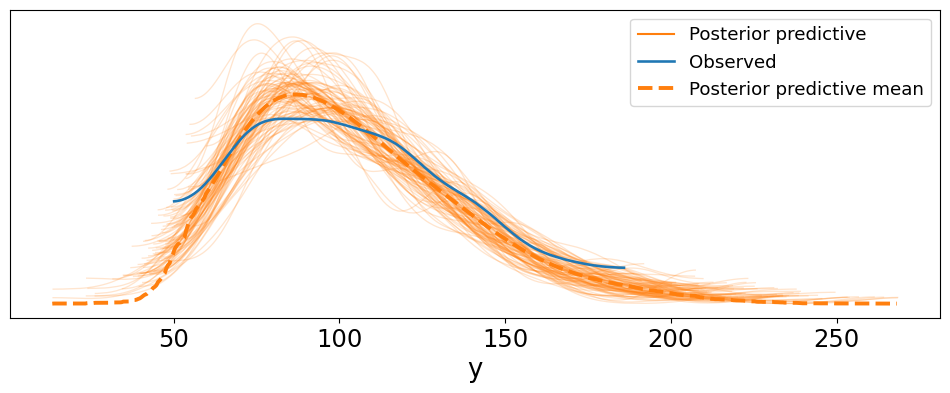

In [14]:
az.plot_ppc(fritz_info2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This was a lot more successful. The skew aligns better with the observed data and the shape of the graph generally seems like it aligns well. My normal skew function does have a bit more of an extreme peak, but that might just be because my amount of data is on the smaller side(about 200 matches). In general, I'm a lot more satisfied with this posterior.

If I had more time/abilities, I think I could make this project better by being able to include all of the data from other court types(that would just take a bit more work to find out exactly how much the different types of courts affect his game). It would also be interesting to include data from his matches that were best 3 out of 5, though that might've had to have been an entirely different graph since match length changes so much.